In [1]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed

set_random_seed(0)

# Disable logging messages unless there is an error
set_log_level("ERROR")

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="Series.view is deprecated")

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
def reformat_forecast(forecast):
  forecast_data = []

  for i in range(8):
      step_col = f"step{i}"
      quantile_20_col = f"step{i} 20.0%"  # Column name for 20th percentile
      quantile_80_col = f"step{i} 80.0%"  # Column name for 80th percentile


      forecast_data.append({
          "ds": forecast["ds"].iloc[0] + pd.Timedelta(hours=i),
          "yhat": forecast[step_col].iloc[0],
          "yhat_lower": forecast[quantile_20_col].iloc[0],  # Add lower bound (20th percentile)
          "yhat_upper": forecast[quantile_80_col].iloc[0]   # Add upper bound (80th percentile)
      })

  new_forecast_df = pd.DataFrame(forecast_data)
  return new_forecast_df

In [3]:
data = pd.read_csv('https://www.dropbox.com/scl/fi/ksf0nbmmiort5khbrgr61/allData.csv?rlkey=75e735fjk4ifttjt553ukxt3k&dl=1')
data.ds = pd.to_datetime(data.ds)
data = data.sort_values('ds')
data['y']=data['POD_GREEN_TBS']+data['POD_YELLOW_TBS']+data['POD_ORANGE_TBS']+data['TRG_HALLWAY_TBS']+data['RAZ_TBS']+data['AMBVERTTBS']+data['QTrack_TBS']+data['Garage_TBS']
df= data.copy()
# regressors='Inflow_Total'
# regressors = df.columns.tolist()
# regressors.remove('y')
# regressors.remove('ds')
# for col in regressors:
#     try:
#         df[col] = pd.to_numeric(df[col], errors='coerce')
#     except (ValueError, TypeError):
#         print(f"Warning: Could not convert column '{col}' to numeric. Skipping...")
# df = df[['ds','y', 'Inflow_Total']]
df.tail()


,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,AMBVERTTBS,QTrack_TBS,Garage_TBS,RAZ_CONS_MORE2H,RAZ_IMCONS_MORE4H,RAZ_XRAY_MORE2H,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM,y
36005,2025-02-11 17:00:00,14,120,1,60,15,180,2,29,1,...,18,10.0,0.0,6,0,0,2,8,2,37.0
36006,2025-02-11 18:00:00,7,127,3,63,10,190,1,30,1,...,15,10.0,0.0,8,0,1,2,8,2,30.0
36007,2025-02-11 19:00:00,8,135,3,66,11,201,3,33,1,...,17,8.0,0.0,8,0,1,4,6,2,29.0
36008,2025-02-11 20:00:00,9,144,3,69,12,213,4,37,1,...,15,5.0,0.0,10,0,3,6,6,2,28.0
36009,2025-02-11 21:00:00,8,152,5,74,13,226,3,40,1,...,12,0.0,0.0,7,0,2,4,6,3,17.0


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 46. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



   train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
9    0.055125       0.0  5.191881  6.783614  0.055156      0.0      9


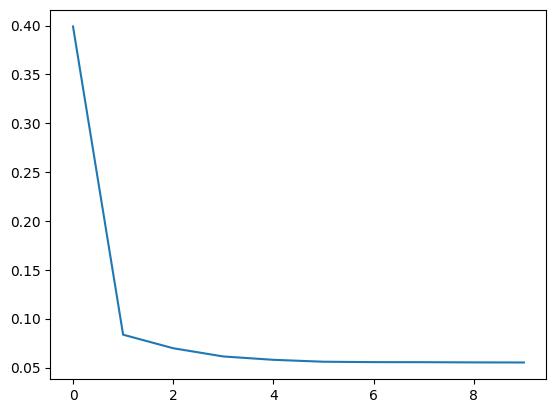

In [5]:
params = {
    'growth':'off',
    'yearly_seasonality': True,
    'weekly_seasonality': True,
    'daily_seasonality': True,
    'n_lags': 48,
    'n_forecasts': 8,
    'epochs':10,
    # 'changepoints_range': 0.95,
    # 'n_changepoints': 50,
    'quantiles': [0.2, 0.5, 0.8]
    # num_hidden_layers=4,
    # d_hidden=36,
    # learning_rate=0.005,

}

m = NeuralProphet(**params)
m.set_plotting_backend("plotly-static")
# m = m.add_lagged_regressor(names=regressors)
# m = m.add_country_holidays("CA")
set_random_seed(42)
metrics = m.fit(df[['ds','y']], freq='h', progress='plot')

print(metrics.tail(1))

In [7]:
df_future = m.make_future_dataframe(df[['ds','y']], periods=8)
forecast = m.predict(df_future, decompose=False, raw=True)
forecast

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])



Predicting: |          | 0/? [00:00<?, ?it/s]

,ds,step0,step0 20.0%,step0 80.0%,step1,step1 20.0%,step1 80.0%,step2,step2 20.0%,step2 80.0%,...,step4 80.0%,step5,step5 20.0%,step5 80.0%,step6,step6 20.0%,step6 80.0%,step7,step7 20.0%,step7 80.0%
0,2025-02-11 22:00:00,16.604824,13.008848,20.016758,14.268539,12.664816,19.564589,15.82102,11.67563,19.669945,...,17.242315,12.679874,7.68156,14.078713,9.170945,6.849759,11.713771,6.552832,3.79587,9.891298


In [8]:
output_df = reformat_forecast(forecast)
output_df

,ds,yhat,yhat_lower,yhat_upper
0,2025-02-11 22:00:00,16.604824,13.008848,20.016758
1,2025-02-11 23:00:00,14.268539,12.664816,19.564589
2,2025-02-12 00:00:00,15.821020,11.675630,19.669945
3,2025-02-12 01:00:00,14.993046,10.144195,16.338875
4,2025-02-12 02:00:00,13.530932,11.852243,17.242315
5,2025-02-12 03:00:00,12.679874,7.681560,14.078713
6,2025-02-12 04:00:00,9.170945,6.849759,11.713771
7,2025-02-12 05:00:00,6.552832,3.795870,9.891298
